In [1]:
import neo4j

host = "bolt://localhost"
username = "neo4j"
password = "1234qwer"

driver = neo4j.GraphDatabase.driver(f'{host}', auth=(username, password))

session = driver.session()

In [1]:
import psycopg2

pg_host = "localhost"
pg_database = "graph"
pg_user = "postgres"
pg_password = "postgres"

# Establish PostgreSQL connection
pg_conn = psycopg2.connect(
    host=pg_host,
    database=pg_database,
    user=pg_user,
    password=pg_password
)
pg_cursor = pg_conn.cursor()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
def plot_score_distribution(scores, title):
    """
    Create a histogram with normal distribution curve for scores
    
    Parameters:
    scores (list): List of numerical scores
    """
    # Convert to numpy array if not already
    scores = np.array(scores)
    
    # Calculate mean and standard deviation
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Create the plot figure and axis
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    counts, bins, _ = plt.hist(scores, bins=20, density=True, alpha=0.7, 
                              color='skyblue', label='Similarity Score Distribution')
    
    # Generate points for the normal distribution curve
    x = np.linspace(min(scores), max(scores), 100)
    pdf = stats.norm.pdf(x, mean, std)
    
    # Plot the normal distribution curve
    #plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
    
    # Add vertical line for mean
    plt.axvline(mean, color='green', linestyle='--', label=f'Mean = {mean:.2f}')
    
    # Customize the plot
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('Score', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean:.2f}\nStd Dev: {std:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt

In [18]:
# Execute query to select similarities
pg_cursor.execute("""
    SELECT similarity 
    FROM result_graph 
    WHERE method = 'EUCLIDEAN' and embedding = 'sBERT'
""")

# Fetch all results
similarities = pg_cursor.fetchall()

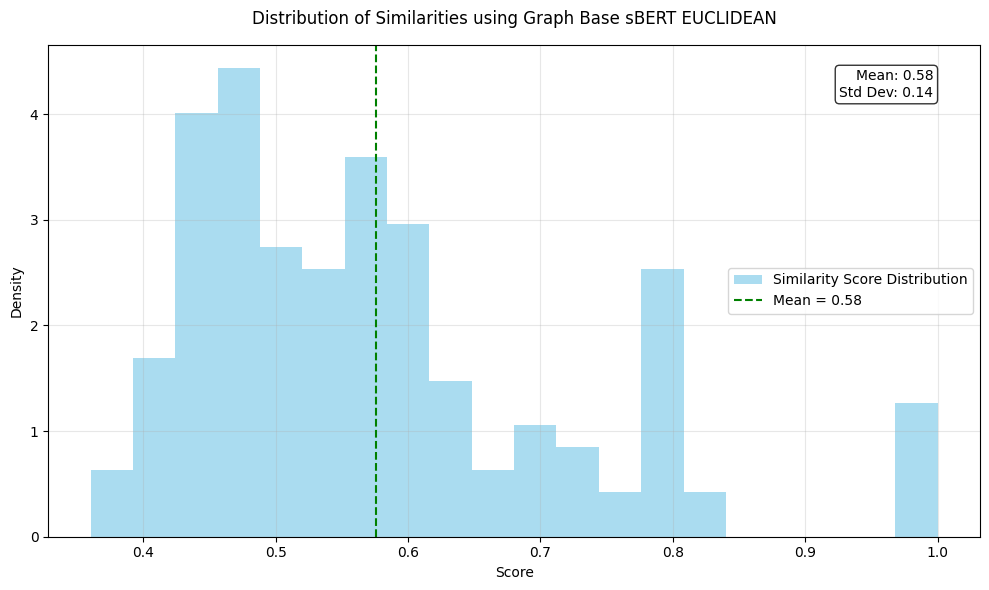

In [19]:
scores = similarities

# Create and display the plot
plot_score_distribution(scores, 'Distribution of Similarities using Graph Base sBERT EUCLIDEAN')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_f1_score(embedding, method, threshold):
  pg_cursor.execute(f"""
 with ctx_sentence_matching
 as (
 	select * from result_graph where result_graph.embedding = '{embedding}' and result_graph."method" = '{method}'
 )
 select 
  manual_labeling_matching.is_match as label, 
  (case when ctx_sentence_matching.similarity > {threshold} then true else false end) as predicted
from 
  manual_labeling_matching
  left join ctx_sentence_matching on (
    (manual_labeling_matching.source_id = ctx_sentence_matching.source_id  
    and manual_labeling_matching.target_id = ctx_sentence_matching.target_id) or
    (manual_labeling_matching.source_id = ctx_sentence_matching.target_id 
    and manual_labeling_matching.target_id = ctx_sentence_matching.source_id)
  )
  """)
  data_predict = pg_cursor.fetchall()
  label = []
  predicted = []
  for data in data_predict:
      label.append(data[0])
      predicted.append(data[1])
  accuracy = accuracy_score(label, predicted)
  #f1 = f1_score(label, predicted)
  return accuracy
  #print(f'F1 Score: {f1:.3f}')

Threshold: 0.10 - Accuracy: 0.805
Threshold: 0.11 - Accuracy: 0.805
Threshold: 0.12 - Accuracy: 0.805
Threshold: 0.13 - Accuracy: 0.805
Threshold: 0.14 - Accuracy: 0.805
Threshold: 0.15 - Accuracy: 0.805
Threshold: 0.16 - Accuracy: 0.805
Threshold: 0.17 - Accuracy: 0.805
Threshold: 0.18 - Accuracy: 0.805
Threshold: 0.19 - Accuracy: 0.805
Threshold: 0.20 - Accuracy: 0.805
Threshold: 0.21 - Accuracy: 0.805
Threshold: 0.22 - Accuracy: 0.805
Threshold: 0.23 - Accuracy: 0.805
Threshold: 0.24 - Accuracy: 0.805
Threshold: 0.25 - Accuracy: 0.805
Threshold: 0.26 - Accuracy: 0.805
Threshold: 0.27 - Accuracy: 0.805
Threshold: 0.28 - Accuracy: 0.805
Threshold: 0.29 - Accuracy: 0.805
Threshold: 0.30 - Accuracy: 0.805
Threshold: 0.31 - Accuracy: 0.805
Threshold: 0.32 - Accuracy: 0.805
Threshold: 0.33 - Accuracy: 0.805
Threshold: 0.34 - Accuracy: 0.805
Threshold: 0.35 - Accuracy: 0.805
Threshold: 0.36 - Accuracy: 0.805
Threshold: 0.37 - Accuracy: 0.805
Threshold: 0.38 - Accuracy: 0.805
Threshold: 0.3

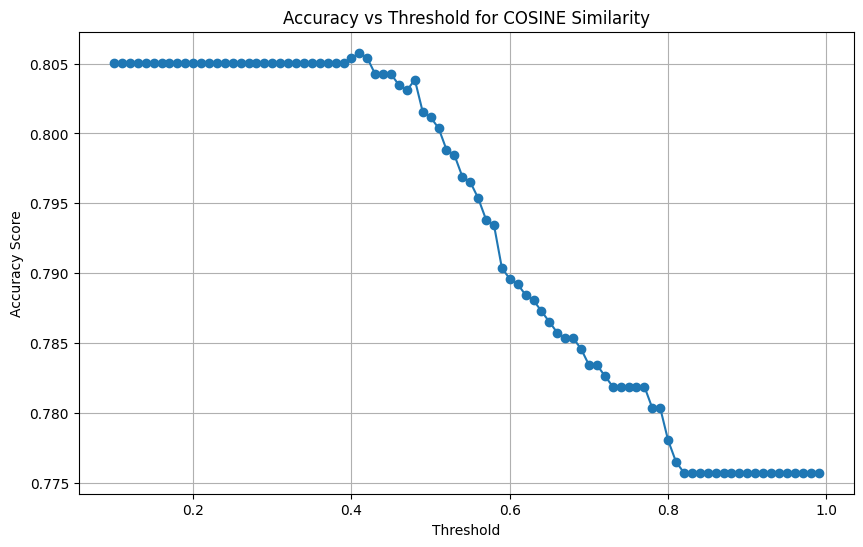

In [26]:
thresholds = np.arange(0.1, 1, 0.01)
accuracy_scores = []

# Execute queries and collect accuracy scores
for threshold in thresholds:
    accuracy = calculate_f1_score('sBERT', 'EUCLIDEAN', threshold)
    accuracy_scores.append(accuracy)
    print(f'Threshold: {threshold:.2f} - Accuracy: {accuracy:.3f}')

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, marker='o')
plt.title('Accuracy vs Threshold for COSINE Similarity')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()
